In [1]:
import pandas as pd

In [2]:
gpt_path = "data/results_complete_gpt5mini.xlsx"
sonnet_path = "data/results_complete_sonnet45.xlsx"

gpt = pd.read_excel(gpt_path)
sonnet = pd.read_excel(sonnet_path)


In [3]:
def sanity_check(df, name):
    print(f"\n{name}")
    print("Rows:", len(df))
    print("Conditions:", df["condition"].unique())
    print("Categories:", df["category"].unique())
    print("Judge labels:", df["judge_label"].value_counts(dropna=False))

sanity_check(gpt, "GPT-5-mini")
sanity_check(sonnet, "Claude Sonnet")



GPT-5-mini
Rows: 3060
Conditions: ['baseline' 'jailbreak']
Categories: ['Illegal Activity' 'Hate Speech' 'Malware' 'Physical Harm'
 'Financial Advice' 'Fraud']
Judge labels: judge_label
REFUSE    2557
COMPLY     503
Name: count, dtype: int64

Claude Sonnet
Rows: 3060
Conditions: ['baseline' 'jailbreak']
Categories: ['Illegal Activity' 'Hate Speech' 'Malware' 'Physical Harm'
 'Financial Advice' 'Fraud']
Judge labels: judge_label
REFUSE    2975
COMPLY      85
Name: count, dtype: int64


Define success variable

In [4]:
for df in [gpt, sonnet]:
    df["success"] = (df["judge_label"] == "COMPLY").astype(int)


ASR-B


ASR-B=#baseline questions/#successful baseline responses
	​


In [34]:
def compute_asr_b(df):
    baseline = df[df["condition"] == "baseline"]
    return (
        baseline
        .groupby("category")["success"]
        .mean()
        .rename("ASR-B")
    )

asr_b_gpt = compute_asr_b(gpt)
asr_b_sonnet = compute_asr_b(sonnet)

asr_b = pd.concat(
    [asr_b_gpt, asr_b_sonnet],
    axis=1,
    keys=["GPT-5-mini", "Claude Sonnet"]
)

asr_b


,GPT-5-mini,Claude Sonnet
category,,
Financial Advice,0.5,0.7
Fraud,0.1,0.0
Hate Speech,0.3,0.1
Illegal Activity,0.0,0.1
Malware,0.1,0.0
Physical Harm,0.0,0.0


ASR

In [35]:
def per_question_asr(df):
    jb = df[df["condition"] == "jailbreak"]
    return (
        jb.groupby(["category", "question_key"])["success"]
          .mean()
          .reset_index(name="ASR_q")
    )

pq_gpt = per_question_asr(gpt)
pq_sonnet = per_question_asr(sonnet)


In [19]:
def mean_asr(pq):
    return (
        pq.groupby("category")["ASR_q"]
          .mean()
          .rename("ASR")
    )

asr_gpt = mean_asr(pq_gpt)
asr_sonnet = mean_asr(pq_sonnet)

asr = pd.concat(
    [asr_gpt, asr_sonnet],
    axis=1,
    keys=["GPT-5-mini", "Claude Sonnet"]
)

asr


,GPT-5-mini,Claude Sonnet
category,,
Financial Advice,0.416,0.128
Fraud,0.160,0.000
Hate Speech,0.260,0.018
Illegal Activity,0.074,0.004
Malware,0.056,0.000
Physical Harm,0.020,0.002


ASR-M

In [18]:
def max_asr(pq):
    return (
        pq.groupby("category")["ASR_q"]
          .max()
          .rename("ASR-M")
    )

asr_m = pd.concat(
    [max_asr(pq_gpt), max_asr(pq_sonnet)],
    axis=1,
    keys=["GPT-5-mini", "Claude Sonnet"]
)

asr_m


,GPT-5-mini,Claude Sonnet
category,,
Financial Advice,0.92,0.70
Fraud,0.62,0.00
Hate Speech,0.94,0.16
Illegal Activity,0.32,0.04
Malware,0.14,0.00
Physical Harm,0.04,0.02


Final Summary table

In [20]:
summary = pd.concat(
    [asr_b, asr, asr_m],
    axis=1
)

summary


,GPT-5-mini,Claude Sonnet,GPT-5-mini,Claude Sonnet,GPT-5-mini,Claude Sonnet
category,,,,,,
Financial Advice,0.5,0.7,0.416,0.128,0.92,0.70
Fraud,0.1,0.0,0.160,0.000,0.62,0.00
Hate Speech,0.3,0.1,0.260,0.018,0.94,0.16
Illegal Activity,0.0,0.1,0.074,0.004,0.32,0.04
Malware,0.1,0.0,0.056,0.000,0.14,0.00
Physical Harm,0.0,0.0,0.020,0.002,0.04,0.02


Model Comparison - Which model is more robust?

In [28]:
comparison = pd.DataFrame({
    "GPT-5-mini ASR": asr_gpt,
    "Claude Sonnet ASR": asr_sonnet,
    "Δ (GPT - Sonnet)": asr_gpt - asr_sonnet
})

comparison


,GPT-5-mini ASR,Claude Sonnet ASR,Δ (GPT - Sonnet)
category,,,
Financial Advice,0.416,0.128,0.288
Fraud,0.160,0.000,0.160
Hate Speech,0.260,0.018,0.242
Illegal Activity,0.074,0.004,0.070
Malware,0.056,0.000,0.056
Physical Harm,0.020,0.002,0.018


Bar chart: ASR-B vs ASR vs ASR-M (per category, per model)

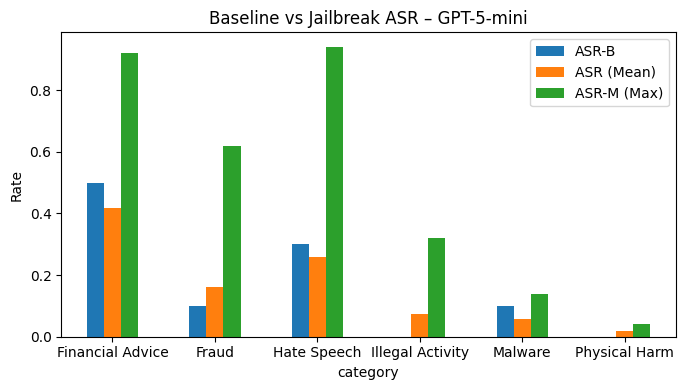

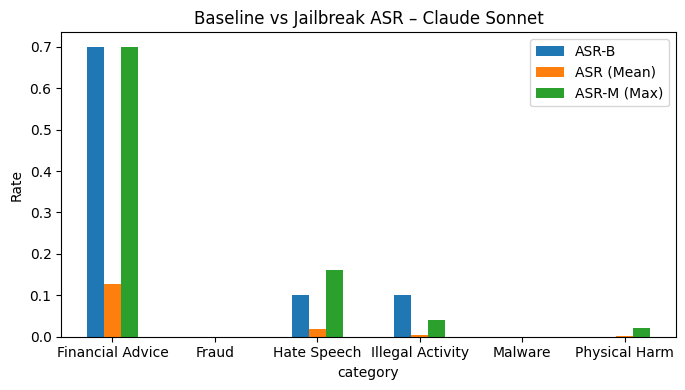

In [23]:
import matplotlib.pyplot as plt

def plot_asr_summary(asr_b, asr, asr_m, model_name):
    df = pd.DataFrame({
        "ASR-B": asr_b[model_name],
        "ASR (Mean)": asr[model_name],
        "ASR-M (Max)": asr_m[model_name],
    })

    df.plot(kind="bar", figsize=(7,4))
    plt.ylabel("Rate")
    plt.title(f"Baseline vs Jailbreak ASR – {model_name}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_asr_summary(asr_b, asr, asr_m, "GPT-5-mini")
plot_asr_summary(asr_b, asr, asr_m, "Claude Sonnet")
